This notebook shows the application of LSTM to predict the global temperature map.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn

from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

In [4]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

In [5]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack({"stacked": ("latitude", "longitude")})
y_train_df = pd.DataFrame(y_train_df.to_pandas())

In [6]:
X_train_df.head()

,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


In [7]:
y_train_df.head()

latitude      -90.0                                                    \
longitude     0.0       2.5       5.0       7.5       10.0      12.5    
time                                                                    
0          0.320023  0.319946  0.319865  0.319885  0.319860  0.319865   
1         -0.667297 -0.667023 -0.667114 -0.667109 -0.667109 -0.667135   
2         -0.058345 -0.058167 -0.058248 -0.058243 -0.058248 -0.058248   
3          0.125870  0.125941  0.125946  0.125941  0.125946  0.125890   
4          0.418304  0.418533  0.418503  0.418523  0.418477  0.418513   

latitude                                           ...      90.0            \
longitude     15.0      17.5      20.0      22.5   ...     335.0     337.5   
time                                               ...                       
0          0.319870  0.319911  0.319763  0.319707  ...  0.913116  0.913289   
1         -0.667114 -0.667104 -0.667104 -0.666992  ...  0.042501  0.042679   
2         -0.058233 -0.058207 -0.058345 -0.058177  ...  1.167440  1.167389   
3          0.125951  0.125941  0.125895  0.125982  ... -0.339457 -0.339589   
4          0.418503  0.418549  0.418482  0.418564  ...  0.577006  0.576996   

latitude                                                               \
longitude     340.0     342.5     345.0     347.5     350.0     352.5   
time                                                                    
0          0.913116  0.912933  0.912893  0.912659  0.912384  0.912181   
1          0.049225  0.055695  0.055506  0.055227  0.054789  0.054230   
2          1.169657  1.172119  1.172201  1.172190  1.172292  1.172424   
3         -0.332387 -0.324961 -0.324956 -0.325038 -0.325063 -0.325033   
4          0.585297  0.593811  0.593740  0.593719  0.593648  0.593801   

latitude                       
longitude     355.0     357.5  
time                           
0          0.911825  0.911611  
1          0.053604  0.052897  
2          1.172709  1.173228  
3         -0.325022 -0.324880  
4          0.593760  0.593943  

[5 rows x 13824 columns]

#### Data normalization

In [8]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape)

(753, 2) (753, 13824) (86, 2)


#### Reshape data to feed into the LSTM model

The LSTM needs data with the format of **[samples, time steps, features]**

Here the lag time step is set to **5**

In [9]:
start = np.cumsum(X_length) - X_length
end   = np.cumsum(X_length)

slider = 5
X_train_all = []
y_train_all = []

for i in range(len(X_length)):
    
    X_subset = X_train[start[i]:end[i],:]
    y_subset = y_train[start[i]:end[i],:]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, X_length[i]-slider+1)])
    
    X_train_all.append(X_subset)
    y_train_all.append(y_subset)
    
X_train = np.concatenate(X_train_all,axis=0)
y_train = np.concatenate(y_train_all,axis=0)
X_test  = np.array([X_test[i:i+slider] for i in range(0, X_test.shape[0]-slider+1)])
print(X_train.shape,y_train.shape,X_test.shape)

(729, 5, 2) (729, 1, 13824) (82, 5, 2)


In [10]:
# Convert to PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), \
                                               torch.FloatTensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test))

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

### 2. Define the LSTM structure

In [11]:
# set hyperparameters
n_neuron       = 64
activation     = 'ReLU'
num_epochs     = 100
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [12]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation="ReLU", num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            getattr(nn, activation)(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)        # [batch, seq_len, hidden]
        x = out[:, -1, :]            # last timestep output
        x = self.fc(x)
        return x

model = LSTMModel(
    input_size=X_train.shape[2],
    hidden_size=n_neuron,
    output_size=y_train.shape[-1],
    activation = activation,
    num_layers=2
)


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [15]:
model.to(device)

LSTMModel(
  (lstm): LSTM(2, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=13824, bias=True)
  )
)

### 3. Train & save the NN model

In [16]:
from utils import pytorch_train
# we will be using the same function as seen in the CNN_example.ipynb notebook 

train_losses_mse, val_losses_mse = pytorch_train(model, optimizer, criterion = criterion, 
                                                 device = device, 
                                                 train_loader = train_loader, val_loader = val_loader, 
                                                 num_epochs = num_epochs)

/srv/conda/envs/notebook/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1, 13824])) that is different to the input size (torch.Size([64, 13824])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/srv/conda/envs/notebook/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7, 1, 13824])) that is different to the input size (torch.Size([7, 13824])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/srv/conda/envs/notebook/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([18, 1, 13824])) that is different to the input size (torch.Size([18, 13824])). This will likely lead to incorrect results due 

Epoch 1/100, Train Loss: 3.1936, Val Loss: 2.7445
Epoch 2/100, Train Loss: 3.0851, Val Loss: 2.5732
Epoch 3/100, Train Loss: 2.7377, Val Loss: 2.2214
Epoch 4/100, Train Loss: 2.4447, Val Loss: 2.0155
Epoch 5/100, Train Loss: 2.2501, Val Loss: 1.9228
Epoch 6/100, Train Loss: 2.1885, Val Loss: 1.8986
Epoch 7/100, Train Loss: 2.1724, Val Loss: 1.8842
Epoch 8/100, Train Loss: 2.1633, Val Loss: 1.8854
Epoch 9/100, Train Loss: 2.1640, Val Loss: 1.8825
Epoch 10/100, Train Loss: 2.1618, Val Loss: 1.8833
Epoch 11/100, Train Loss: 2.1620, Val Loss: 1.8835
Epoch 12/100, Train Loss: 2.1620, Val Loss: 1.8830
Epoch 13/100, Train Loss: 2.1617, Val Loss: 1.8832
Epoch 14/100, Train Loss: 2.1618, Val Loss: 1.8831
Epoch 15/100, Train Loss: 2.1617, Val Loss: 1.8831
Epoch 16/100, Train Loss: 2.1617, Val Loss: 1.8832
Epoch 17/100, Train Loss: 2.1616, Val Loss: 1.8832
Epoch 18/100, Train Loss: 2.1616, Val Loss: 1.8832
Epoch 19/100, Train Loss: 2.1616, Val Loss: 1.8832
Epoch 20/100, Train Loss: 2.1615, Val Lo

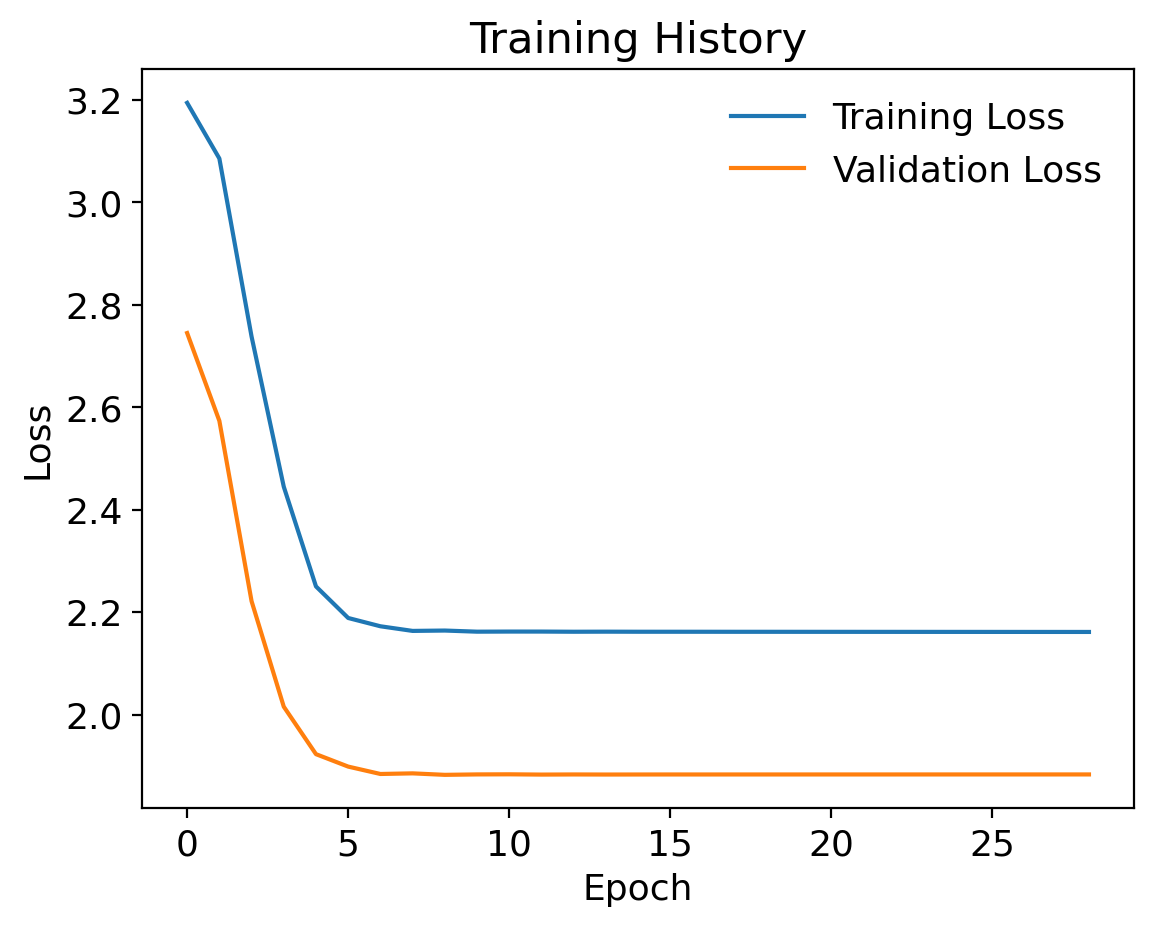

In [17]:
plot_history(train_losses_mse, val_losses_mse)

In [18]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [19]:
# Save the model weights to a pth file.
torch.save(model.state_dict(), os.path.join(model_path,'LSTM_model_weights.pth'))

### 4. Evaluate the trained model

In [20]:
# make new model instances for evaluation (best practice)
model_eval = LSTMModel(
    input_size=X_train.shape[2],
    hidden_size=n_neuron,
    output_size=y_train.shape[-1],
    num_layers=2
)

# reload the saved model weights
state_dict = torch.load(os.path.join(model_path,'LSTM_model_weights.pth'), weights_only=True)
model_eval.load_state_dict(state_dict)

<All keys matched successfully>

In [21]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

model_eval.to(device).eval()
predictions = []
with torch.no_grad():
   for batch_X, in test_loader:
       batch_X = batch_X.to(device)
       outputs = model_eval(batch_X)
       predictions.append(outputs.cpu().numpy())

In [22]:
y_test_pre = np.concatenate(predictions, axis=0)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values[slider-1: ], 
                              'latitude': X_test_xr.latitude.values, 
                              'longitude': X_test_xr.longitude.values},
                      data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

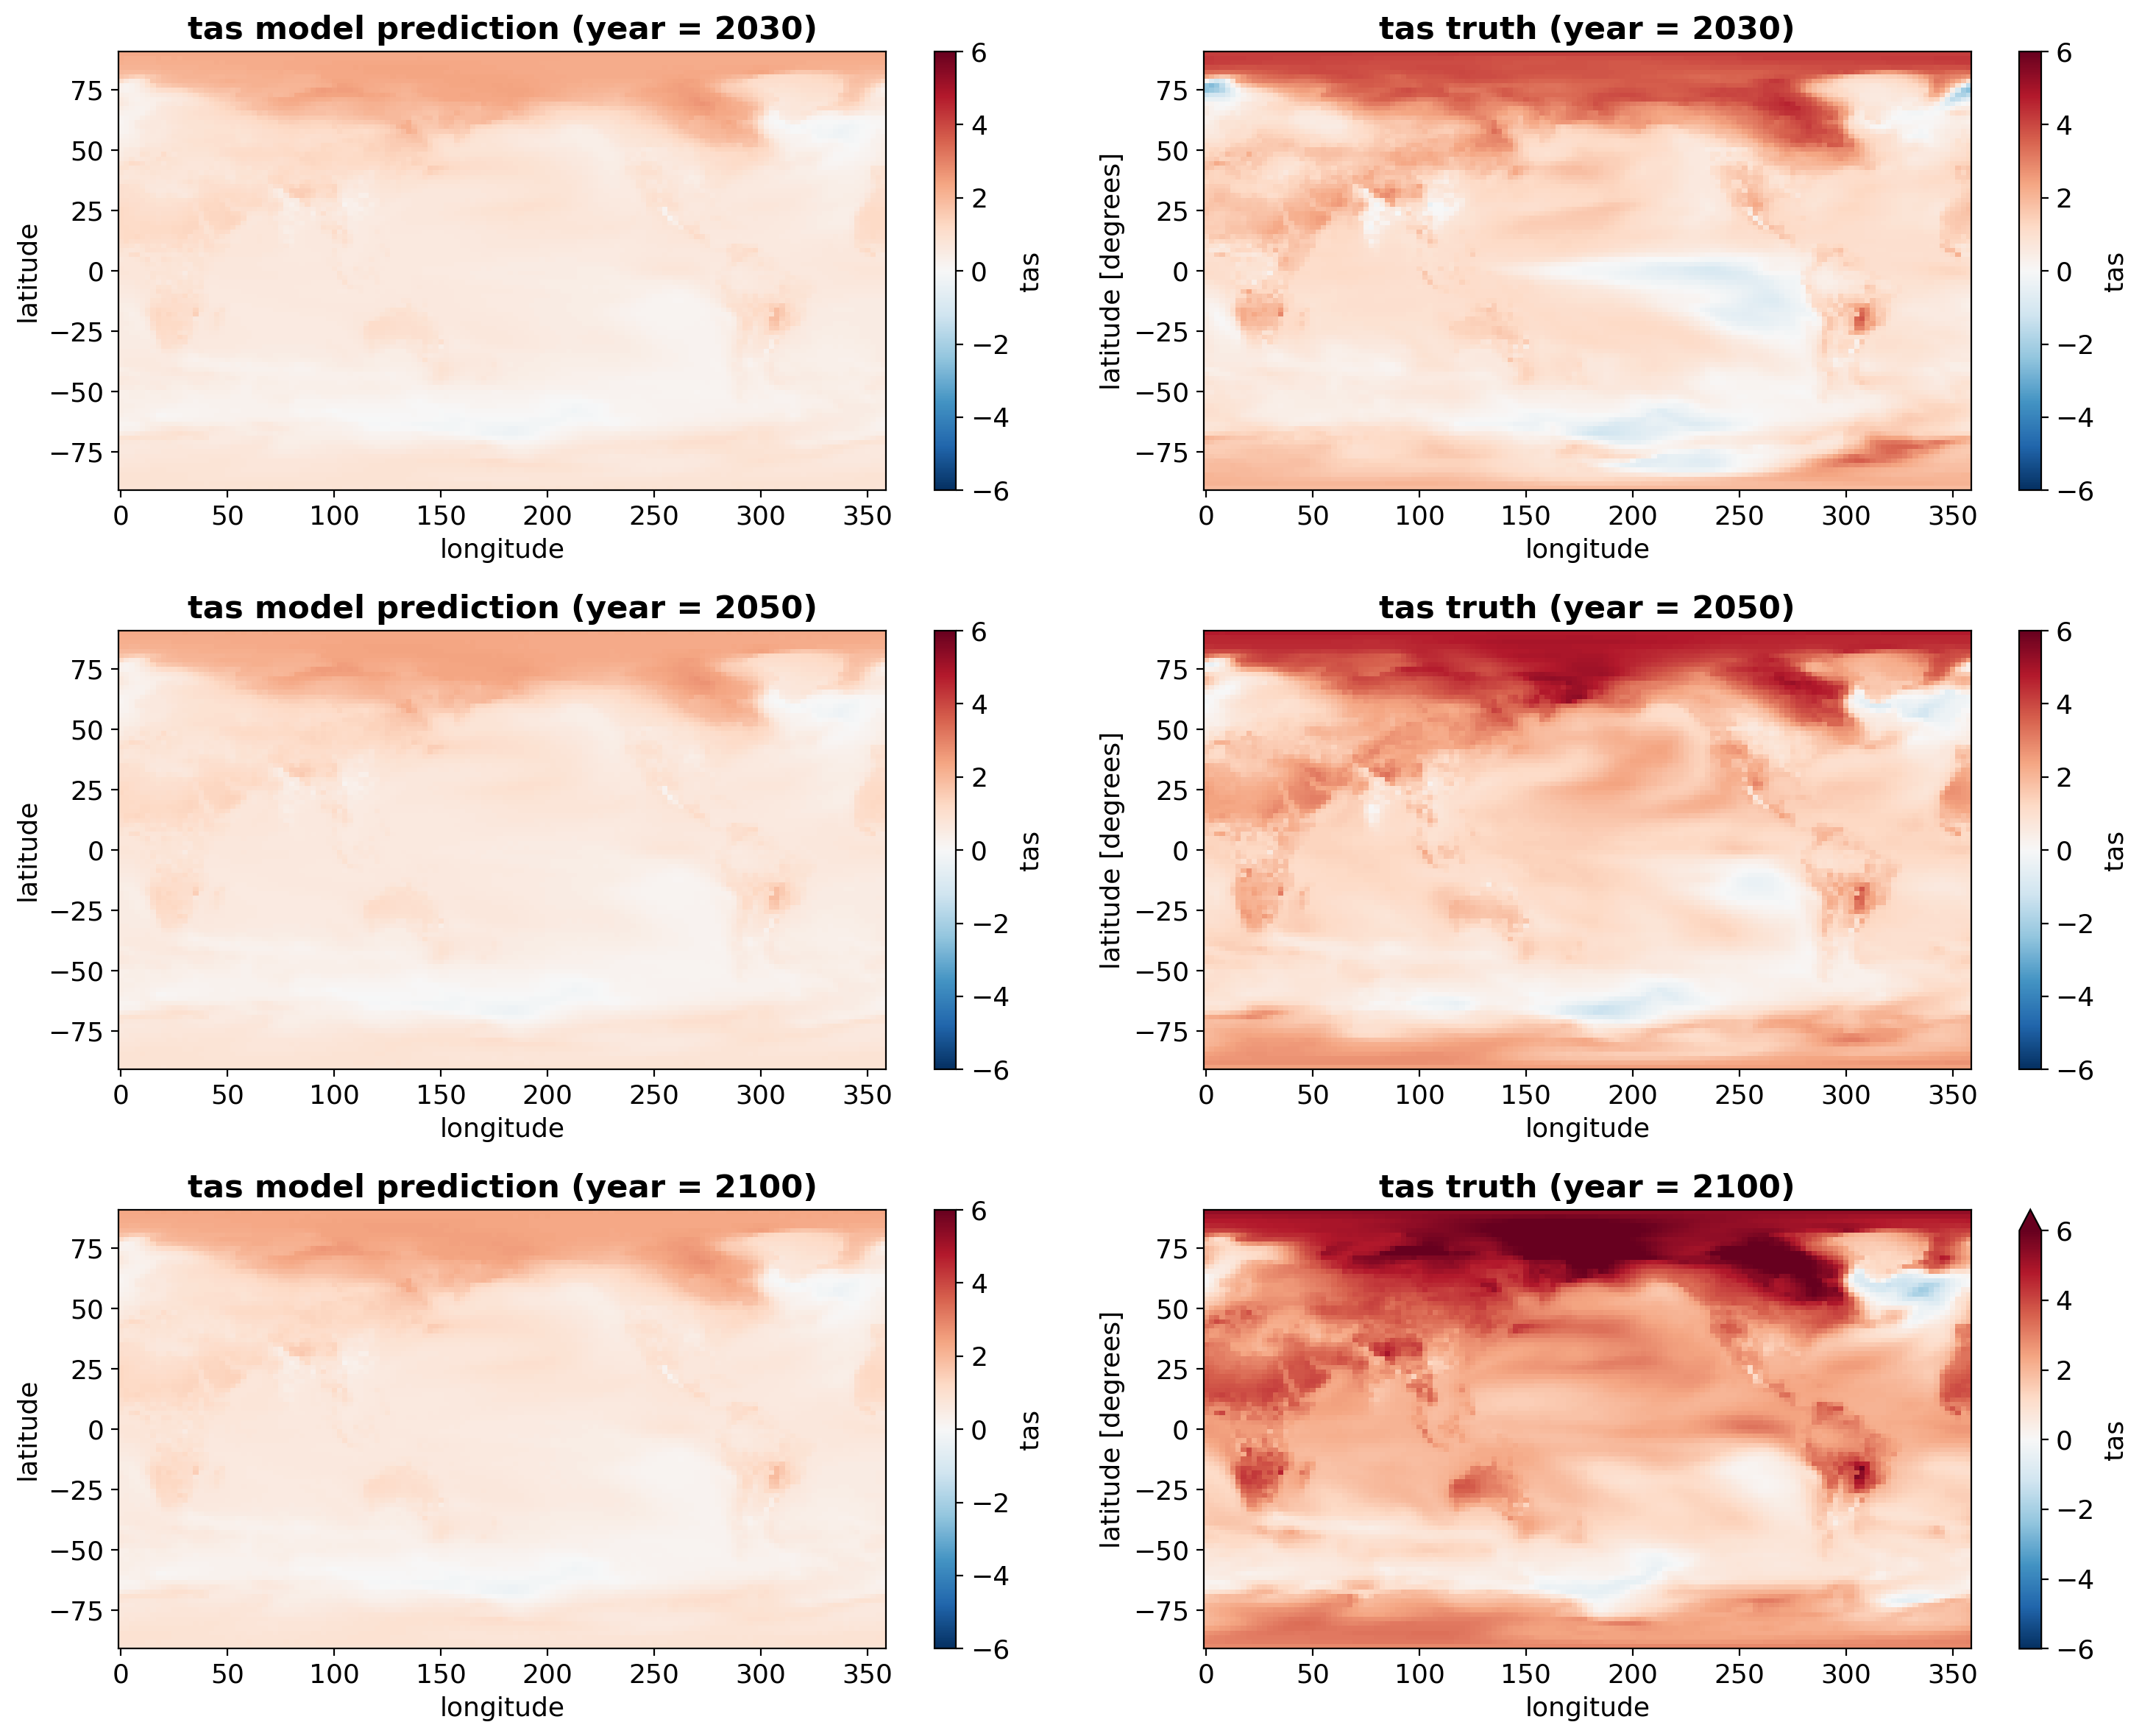

In [23]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

Text(0, 0.5, 'temperature (°C)')

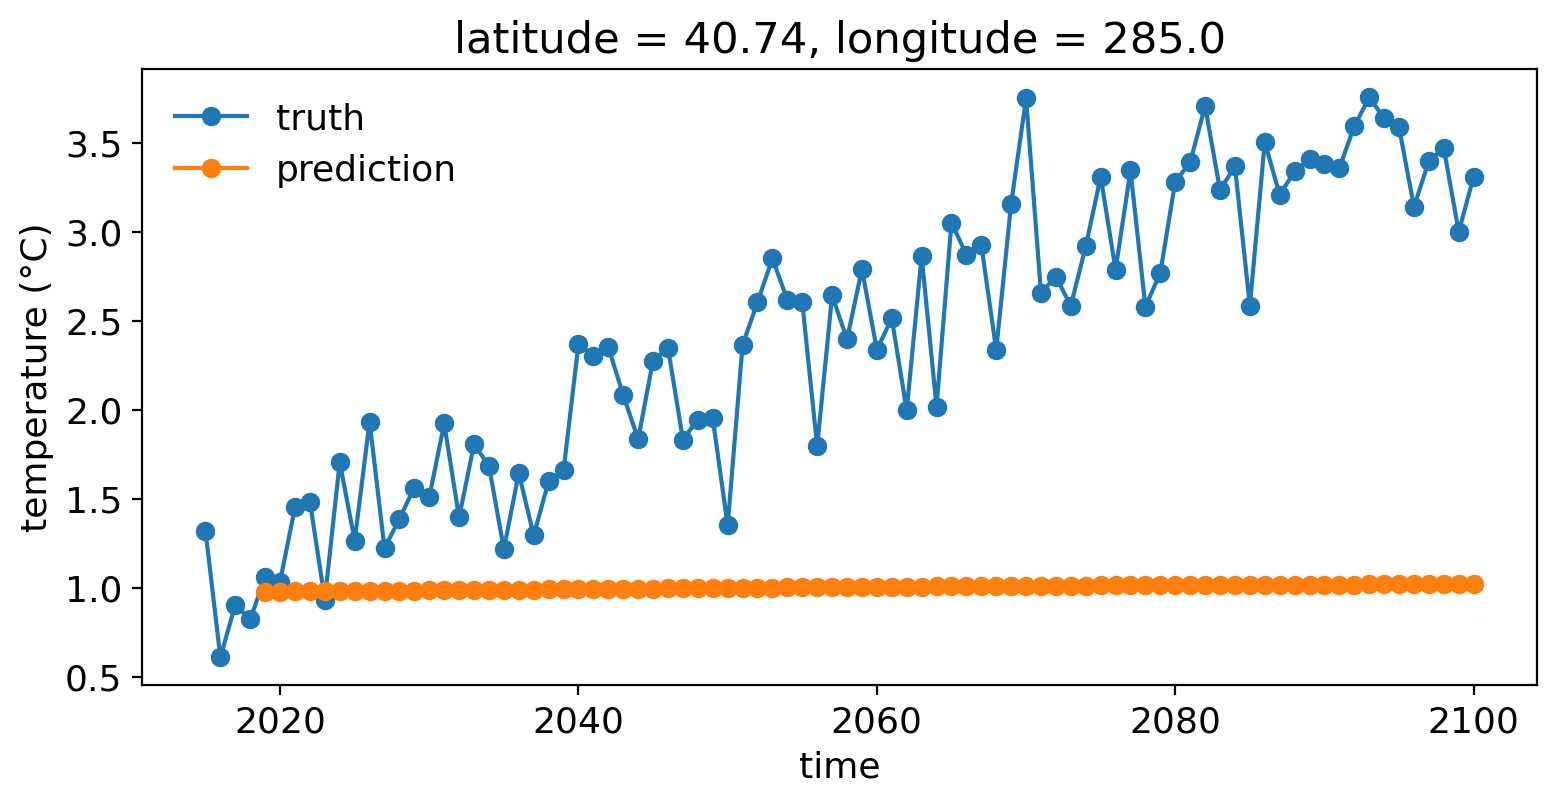

In [24]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction')

ax.legend()
ax.set_ylabel('temperature (°C)')

In [25]:
# combine truth and prediction arrays into a dataframe
nyc_test_xr = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.values
nyc_test_pre = y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values


df_nyc_test = pd.DataFrame()
df_nyc_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_nyc_test["truth"] = nyc_test_xr
df_nyc_test["prediction"] = np.nan
df_nyc_test.loc[4:, "prediction"] = nyc_test_pre # prediction start from 2019
print(df_nyc_test.head(10))

# summary statistics of the dataframe
df_nyc_test.describe()

   time     truth  prediction
0  2015  1.321960         NaN
1  2016  0.608693         NaN
2  2017  0.905599         NaN
3  2018  0.822795         NaN
4  2019  1.061228    0.978157
5  2020  1.035349    0.978813
6  2021  1.451701    0.979476
7  2022  1.484253    0.980143
8  2023  0.934296    0.980810
9  2024  1.707011    0.981472


,time,truth,prediction
count,86.000000,86.000000,82.000000
mean,2057.500000,2.395548,1.003132
std,24.969982,0.836997,0.013103
min,2015.000000,0.608693,0.978157
25%,2036.250000,1.691455,0.992179
50%,2057.500000,2.456390,1.005440
75%,2078.750000,3.155296,1.015015
max,2100.000000,3.757050,1.020324


Finally we check whether the ML model can capture the time series of global average temperature 

In [26]:
def global_mean_std_plot(X,label,color,ax,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)

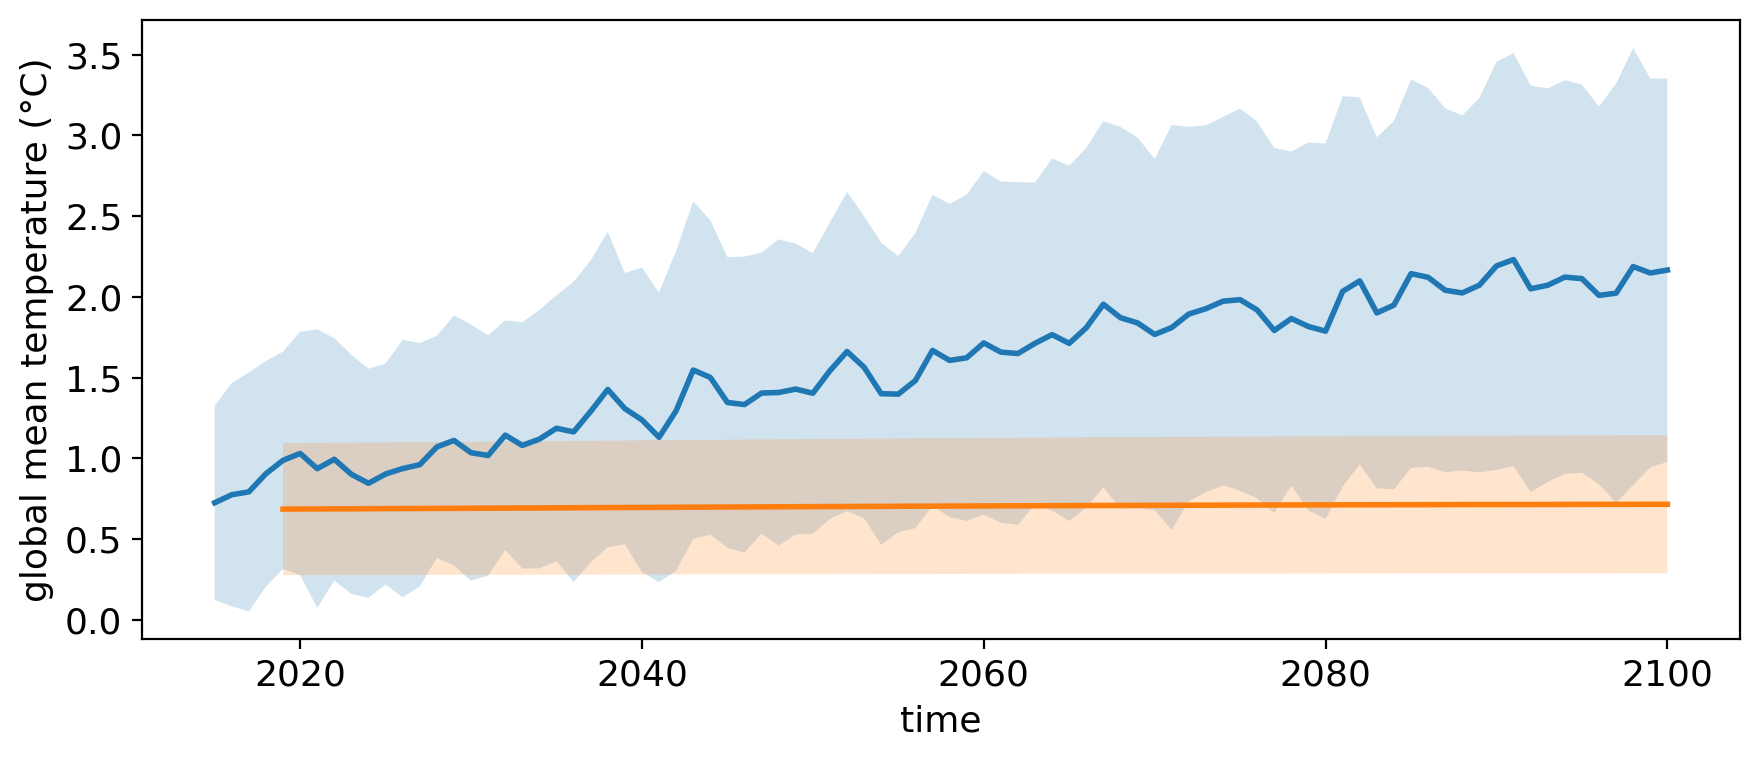

In [27]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_pre,label='prediction',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
plt.tight_layout()

In [28]:
# get global mean temperature
def global_mean(X,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X['tas'].weighted(weights).mean(['latitude', 'longitude']).data
    return tas_mean

tas_mean_xr = global_mean(y_test_xr)
tas_mean_pre = global_mean(y_test_pre)

# put into dataframe
df_globalmean_test = pd.DataFrame()
df_globalmean_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_globalmean_test["truth"] = tas_mean_xr
df_globalmean_test["prediction"] = np.nan
df_globalmean_test.loc[4:, "prediction"] = tas_mean_pre # prediction start from 2019
print(df_globalmean_test.head(10))

# summary statistics of the dataframe
df_globalmean_test.describe()

   time     truth  prediction
0  2015  0.724876         NaN
1  2016  0.774634         NaN
2  2017  0.792321         NaN
3  2018  0.905029         NaN
4  2019  0.987700    0.685633
5  2020  1.030206    0.686097
6  2021  0.935918    0.686566
7  2022  0.994084    0.687037
8  2023  0.900831    0.687508
9  2024  0.845252    0.687974


,time,truth,prediction
count,86.000000,86.000000,82.000000
mean,2057.500000,1.564246,0.703274
std,24.969982,0.430099,0.009246
min,2015.000000,0.724876,0.685633
25%,2036.250000,1.169074,0.695542
50%,2057.500000,1.635698,0.704943
75%,2078.750000,1.943204,0.711657
max,2100.000000,2.230782,0.715354
